In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [31]:
words = open("J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt", "r").read().splitlines()
words[:8]

["Harry Potter and the Sorcerer's Stone",
 '',
 '',
 'CHAPTER ONE',
 '',
 'THE BOY WHO LIVED',
 '',
 'Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say']

In [32]:
len(words)

10702

In [33]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
itos = {i:s for s, i in stoi.items() }
vocab_size = len(chars)
print(f'{itos}\n{vocab_size}')

{1: '\t', 2: ' ', 3: '!', 4: '"', 5: "'", 6: '(', 7: ')', 8: '*', 9: ',', 10: '-', 11: '.', 12: '0', 13: '1', 14: '2', 15: '3', 16: '4', 17: '5', 18: '6', 19: '7', 20: '8', 21: '9', 22: ':', 23: ';', 24: '?', 25: 'A', 26: 'B', 27: 'C', 28: 'D', 29: 'E', 30: 'F', 31: 'G', 32: 'H', 33: 'I', 34: 'J', 35: 'K', 36: 'L', 37: 'M', 38: 'N', 39: 'O', 40: 'P', 41: 'Q', 42: 'R', 43: 'S', 44: 'T', 45: 'U', 46: 'V', 47: 'W', 48: 'X', 49: 'Y', 50: 'Z', 51: '\\', 52: 'a', 53: 'b', 54: 'c', 55: 'd', 56: 'e', 57: 'f', 58: 'g', 59: 'h', 60: 'i', 61: 'j', 62: 'k', 63: 'l', 64: 'm', 65: 'n', 66: 'o', 67: 'p', 68: 'q', 69: 'r', 70: 's', 71: 't', 72: 'u', 73: 'v', 74: 'w', 75: 'x', 76: 'y', 77: 'z', 78: '~'}
78


In [40]:
#setting up the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(F"X shape: {X.shape}, and this is Y shape: {Y.shape}")
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])       # training dataset: 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # validation dataset: 10%
Xte, Yte = build_dataset(words[n2:])       # test dataset: 10%

X shape: torch.Size([351644, 3]), and this is Y shape: torch.Size([351644])
X shape: torch.Size([43288, 3]), and this is Y shape: torch.Size([43288])
X shape: torch.Size([44810, 3]), and this is Y shape: torch.Size([44810])


In [41]:
# setting up the model.
g = torch.Generator().manual_seed(2147483647)
class linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: 
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class Batchnorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters trained with backpropagation
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):  # x is coming from the embeddings vector.
        if self.training:   # if we're training
            xmean = x.mean(0, keepdim=True) # mini-batch mean
            xvar = x.var(0, keepdim=True)   # mini-batch variance
        else:
            xmean = self.running_mean       # mini-batch mean
            xvar = self.running_var         # mini-batch variance
        xhat = (x - xmean) / torch.sqrt((xvar + self.eps))  # normalizing
        self.out = self.gamma * xhat + self.beta      # scaling and shifting
        # update the buffers
        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var  = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embs = 10     # the dimensionality of the character embedding vectors.  
n_hidden = 200  # number of neurons in the hidden layer.

C = torch.randn((vocab_size, n_embs), generator=g)                                     # C = ([10702, 10])
layers = [
    linear(n_embs * block_size, n_hidden, bias=False), Batchnorm1d(n_hidden), Tanh(),
    linear(           n_hidden, n_hidden, bias=False), Batchnorm1d(n_hidden), Tanh(),
    linear(           n_hidden, n_hidden, bias=False), Batchnorm1d(n_hidden), Tanh(),
    linear(           n_hidden, n_hidden, bias=False), Batchnorm1d(n_hidden), Tanh(),
    linear(           n_hidden, n_hidden, bias=False), Batchnorm1d(n_hidden), Tanh(),
    linear(           n_hidden, vocab_size, bias=False), Batchnorm1d(vocab_size),
]

with torch.no_grad():
    # make the last layer less confident
    layers[-1].gamma *= 0.1
    # for all other layer apply the gain
    for layer in layers[:-1]:
        if isinstance(layer, linear):
            layer.weight *= 5/3 # 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f'Number of parameters in total: {sum(p.nelement() for p in parameters)}.')
for p in parameters:
    p.requires_grad = True

Number of parameters in total: 184536.


In [42]:
# trainig the neural network.
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # mini-batch construct.
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)  # ([200])
    Xb, Yb = Xtr[ix], Ytr[ix]  # Xb = ([200, 3])

    # forward pass.
    emb = C[Xb]  # embend the characters into vectors                # C = ([78, 20]),  emb = ([200, 3, 20])
    x = emb.view(emb.shape[0], -1)  # concatenating the vectors      # X = ([32, 60])
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function.

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 15000 else 0.12 # learning rate decay.
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 1000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/  20000: 4.3683
   1000/  20000: 2.5229
   2000/  20000: 2.3659
   3000/  20000: 2.2538
   4000/  20000: 2.3528
   5000/  20000: 1.8540
   6000/  20000: 2.3131
   7000/  20000: 2.3058
   8000/  20000: 1.9193
   9000/  20000: 1.6500
  10000/  20000: 1.8315
  11000/  20000: 1.3309
  12000/  20000: 1.9762
  13000/  20000: 1.7499
  14000/  20000: 2.2343
  15000/  20000: 1.7161
  16000/  20000: 1.9240
  17000/  20000: 2.0007
  18000/  20000: 2.3070
  19000/  20000: 1.5453


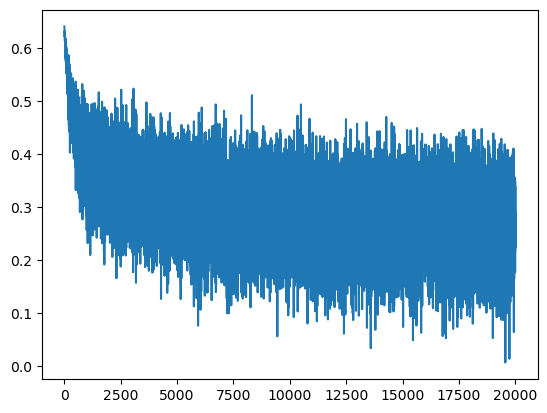

In [43]:
plt.plot(lossi)

Layer 2 (      Tanh): mean +0.00, std 0.68, saturated 7.66%
Layer 5 (      Tanh): mean +0.00, std 0.70, saturated 9.77%
Layer 8 (      Tanh): mean -0.00, std 0.70, saturated 9.12%
Layer 11 (      Tanh): mean -0.01, std 0.71, saturated 8.20%
Layer 14 (      Tanh): mean +0.00, std 0.71, saturated 7.66%


Text(0.5, 1.0, 'Activation distribution.')

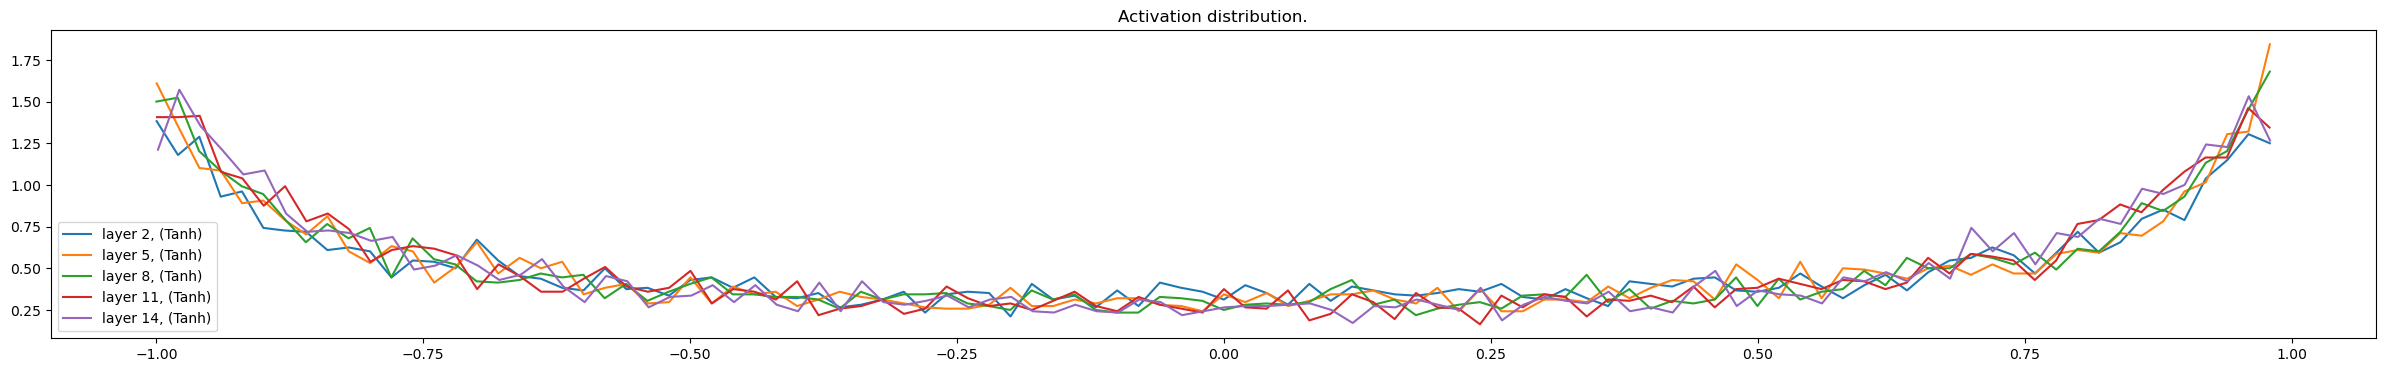

In [44]:
# visualize histograms
plt.figure(figsize=(30, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # all the layer except the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('Layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i}, ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Activation distribution.')

layer 2 (      Tanh): mean +0.000000, std 2.754149e-03
layer 5 (      Tanh): mean +0.000000, std 2.659576e-03
layer 8 (      Tanh): mean +0.000000, std 2.704807e-03
layer 11 (      Tanh): mean -0.000000, std 2.626366e-03
layer 14 (      Tanh): mean -0.000000, std 2.487846e-03


Text(0.5, 1.0, 'Gradient distribution')

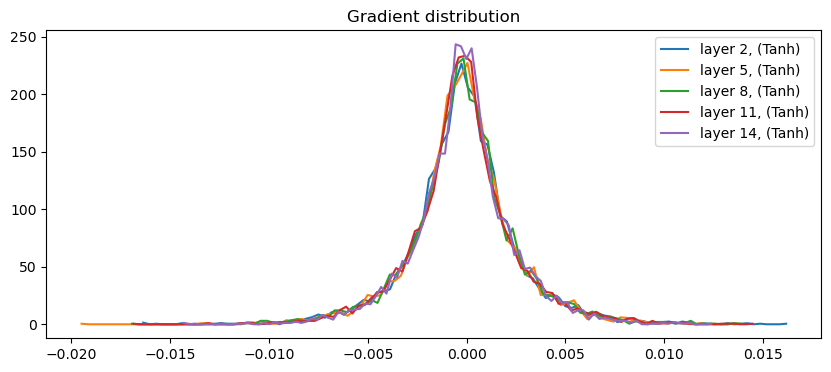

In [45]:
# visualize histograms
plt.figure(figsize=(10, 4))
legends = []
for i, layer in enumerate(layers[:-1]): #excluding the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i}, ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Gradient distribution')

weight   (78, 10) | mean +0.000000 | std 1.040081e-02 | grad:data ratio 1.044799e-02
weight  (30, 200) | mean -0.000078 | std 7.115185e-03 | grad:data ratio 2.160311e-02
weight (200, 200) | mean -0.000004 | std 4.417161e-03 | grad:data ratio 3.144677e-02
weight (200, 200) | mean -0.000013 | std 4.374905e-03 | grad:data ratio 3.153121e-02
weight (200, 200) | mean +0.000012 | std 4.304376e-03 | grad:data ratio 3.132749e-02
weight (200, 200) | mean -0.000020 | std 3.844928e-03 | grad:data ratio 2.870308e-02
weight  (200, 78) | mean -0.000011 | std 5.876302e-03 | grad:data ratio 3.814442e-02


Text(0.5, 1.0, 'weights gradient distribution.')

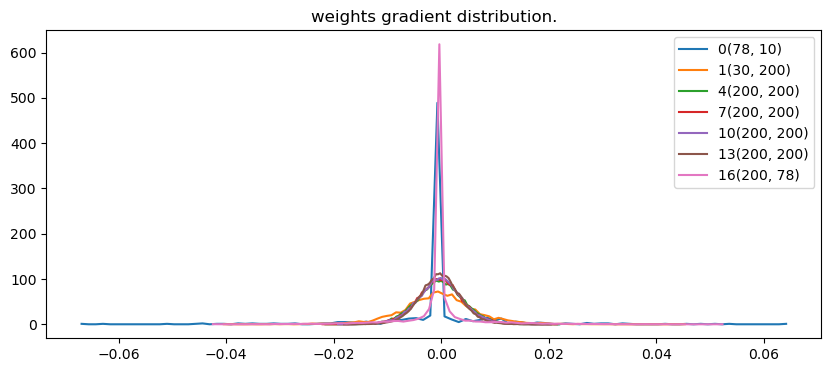

In [46]:
# visualize histograms
plt.figure(figsize=(10, 4))
legends = []
for i, p in enumerate(parameters):  
    t = p.grad
    if p.ndim == 2:  # this is to only getting the weights of the neural net.
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i}{tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution.')

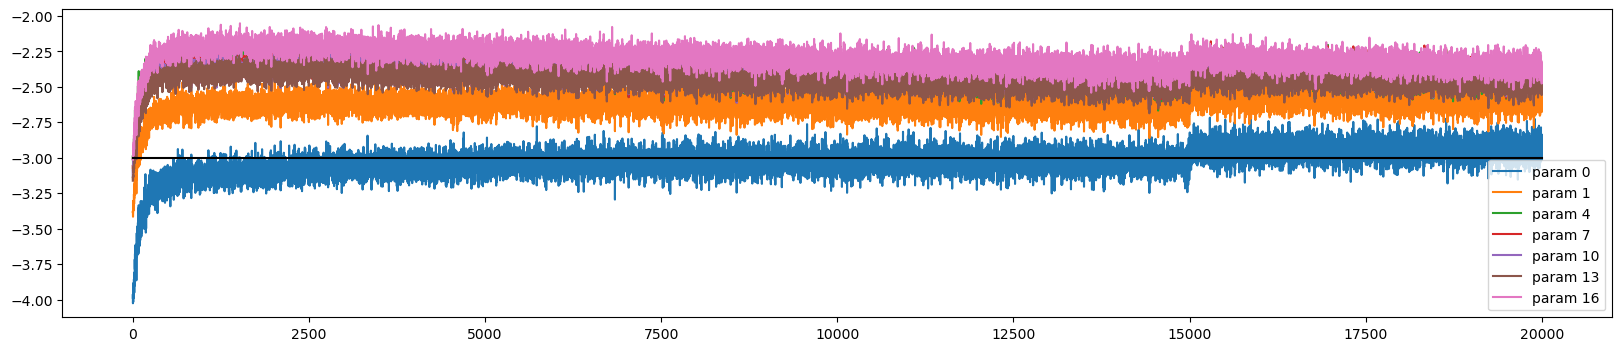

In [47]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2: # only getting the weights
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [48]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'validation': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embs)
    x = emb.view(emb.shape[0], -1) # (concat into: (N, block_size * n_embs))
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layer into evaluation mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('validation')

train 1.760254144668579
validation 1.7737804651260376


In [49]:
# sample from the dataset
g  = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(2000):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the nural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embs)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)    # sample from the distribution.
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 11: # we stop when the output is a dot, in other words, when it is zero. 
            break
    print(''.join(itos[i] for i in out))

all beforning is peen face pofes.
"We's whon'n sitembed the wadterly startle ofYhered t7 a sport, that.
.
.
"She might of that you"doothered'd straid Hermione whis which, Ronly.
.
Weagers pily, badding wogt.
.
des rell', there's whornimat," said out this cPonf please was the which.
that them, stighajger head it they cH.
.
.
.
.
pack dee to the* Harry, He.
.
his sleen the.
.
.
cned.
S3stion, the them this heMT in You be.
wack yer.
.
"Mnagale.
It meadn't shered thought collown bectiers.
.
.
whicked him.
.
.
"Harry?" snr out.
.
"Name in thapt us sire fat turnom.
porld now, tofessort -- int it withe word, Bout at that what the they stuct?" said'ver tome.
"At tho I.
.
.
Ouch ruphed it -- and colargs.
steen could?".
than -- ever.
"What tMop as her.
that had which sptone.
Harry.
" came a -- it.
hear," scted his wered.
There intione?"".
agas, but then to quicked darks in though.
.
Ron".
"Hagrid,.
dothought.


KeyError: 0